<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter12/test_models.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# !pip install git+https://github.com/benman1/time-series.git

In [ ]:
N_EPOCHS = 1

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
import tensorflow as tf

disable_eager_execution()  # for graph mode
tf.compat.v1.experimental.output_all_intermediates(True)

In [5]:
from time_series.dataset.utils import get_energy_demand
from time_series.dataset.time_series import TrainingDataSet

train_df = get_energy_demand()
tds = TrainingDataSet(train_df)

In [6]:
from time_series.utils import evaluate_model

In [7]:
from time_series.models.deepar import DeepAR

ar_model = DeepAR(tds)
ar_model.instantiate_and_fit(verbose=1, epochs=N_EPOCHS)

2021-10-23 17:42:36.129724: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 10)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 4)             240       
_________________________________________________________________
dense (Dense)                (None, 10, 4)             20        
_________________________________________________________________
main_output (GaussianLayer)  [(None, 10, 10), (None, 1 100       
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________
Train on 99336 samples
99336/99336 [==============================] - 20s 206us/sample - loss: 1.2211 - mean_absolute_percentage_error: 355.2895 - mae: 0.6562 - mse: 0.6877

/Users/ben/time_series/env/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


MSE: 0.5547
----------
CT: 1.85
MASS: 2.18
ME: 1.53
NEMASSBOST: 2.43
NH: 2.89
RI: 1.68
SEMASS: 2.11
TOTAL: 2.05
VT: 1.34
WCMASS: 1.94


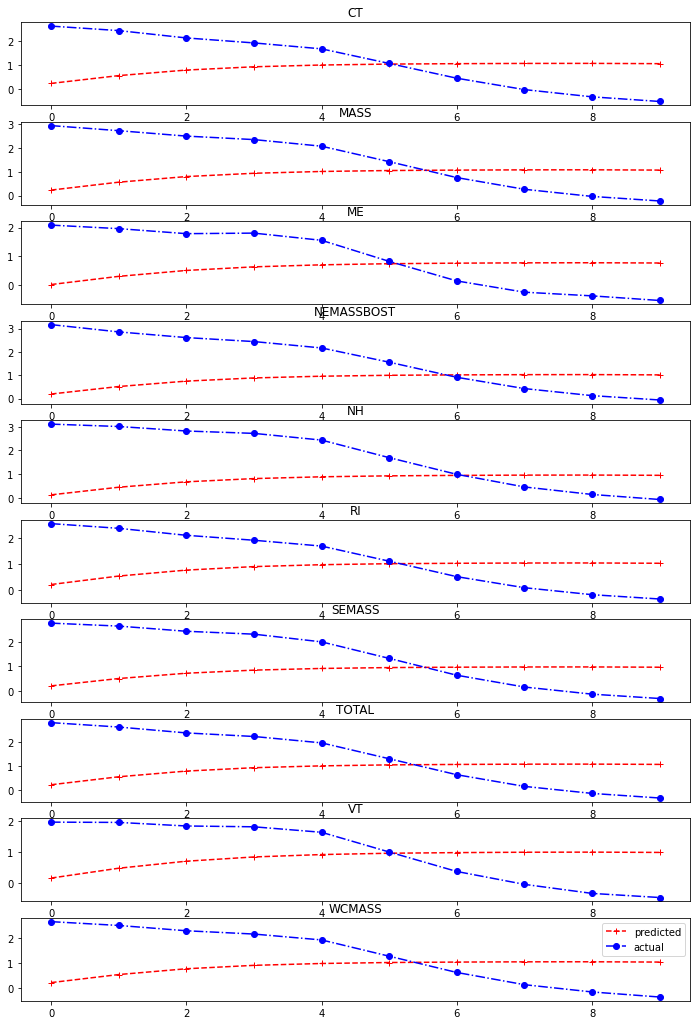

In [8]:
y_predicted = ar_model.model.predict(tds.X_test)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=10)

In [ ]:
from time_series.models.nbeats import NBeatsNet

nb = NBeatsNet(tds)
nb.instantiate_and_fit(verbose=1, epochs=N_EPOCHS)
#y_predicted = nb.model.predict(tds.X_test, steps=10)
#evaluate_model(first_n=10)
print(nb.model.evaluate(tds.X_test, tds.y_test))

Model: "forecast"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     [(None, 10, 10)]     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 10)           0           input_variable[0][0]             
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 10)           0           input_variable[0][0]             
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10)           0           input_variable[0][0]             
___________________________________________________________________________________________

In [ ]:
y_predicted = nb.model.predict(tds.X_test)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=10)

In [ ]:
from time_series.models.LSTM import LSTM
lstm = LSTM(tds)
lstm.instantiate_and_fit(verbose=1, epochs=1000)
#y_predicted = lstm.model.predict(tds.X_test, steps=10)
#evaluate_model(first_n=10)
print(lstm.model.evaluate(tds.X_test, tds.y_test))

In [ ]:
y_predicted = lstm.model.predict(tds.X_test)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=10)

In [ ]:
#tds_1step = TrainingDataSet(train_df, lag=tds.lag, two_dim=False)
#tds_1step.y_test = tds_1step.y_test[:, :, 0]
#tds_1step.y_train = tds_1step.y_train[:, :, 0]

In [ ]:
# only training a 1-step prediction here:
from time_series.models.transformer import Transformer

trans = Transformer(tds)
trans.instantiate_and_fit(verbose=1, epochs=N_EPOCHS)
print(trans.model.evaluate(tds.X_test, tds.y_test))

In [ ]:
y_predicted = trans.model.predict(tds.X_test)  # .reshape(-1, 10)
evaluate_model(tds=tds, y_predicted=y_predicted, columns=train_df.columns, first_n=10)